# Library introduction 
This notebook is a walkthorugh the basic concepts in the PyMTJ library and covers the basics of using the C++ bindings in Python.
In the first section, we will run the basic voltage spin diode experiment using the IEC (Interlayer Exchange Coupling) excitation.  
In the second section, we are going to construct the Spin Torque Oscillator (STO) using the STT (Slonczewski Spin Torque) addition to our LLG equations. STO is able to sustain the magnetisation precession for a prolonged period of time, since the spin-polarised current flowing through the junction compensates the energy losses from the Gilbert's damping contribution.

We start with the definition of our Junction, which in turn is composed from two layers.
Here are some key parameters:
- mag - magnetisation vector
- anis - the vector (axis) of the magnetic anisotoropy 
- K - magnetic anisotropy $[J/m^3]$
- Ms - magnetisation saturation $[T]$
- thickness - thickness of the layer $[m]$
- J - the IEC coupling with the other layers $[J/m^2]$

In [1]:
import numpy as np
import time
from cmtj import Junction, Layer, CVector, ScalarDriver, AxialDriver, NullDriver

In [2]:
N = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
damping = 0.01
cl1 = Layer(id="free",
            mag=CVector(0, 0, 1),
            anis=CVector(0, -0.0871557, 0.996195),
            Ms=1.07,
            thickness=1e-9,
            cellSurface=0,
            demagTensor=N,
            damping=damping)

cl2 = Layer(id="bottom",
            mag=CVector(0, 0, 1),
            anis=CVector(0.34071865, -0.08715574, 0.936116),
            Ms=1.07,
            thickness=1e-9,
            cellSurface=0,
            demagTensor=N,
            damping=damping)

## Voltage Spin Diode effect
As we have defined the Junction, we now proceed to running the Voltage Spin Diode experiment. 

To perform the VSD the external magnetic field is swept in some range, in this case we picked 30 points in range from 0 to 600 mT. For each field point we solve the LLG under the specific excitation and frequency. 

In this example we will be exciting the system with its resonant frequency which is given _a priori_ but you may find it with the FFT analysis included in the PyMTJ package as well. We skipped that part for clarity.
For each of the points we will calculate the constant voltage (Vmix, the diode voltage) arising from the interaction between the sinusoidal current flowing throught the MTJ (of 0 phase and frequency equal to that of the resonant frequency) and also oscillating magnetoresistance, which in turn is invoked by the oscillating magnetisation in response to the effective field contributions.

Other parameters were fixed so that we get a nice result, but feel free to tinker with the options and see what happens. 

In [3]:
from collections import defaultdict
from cmtj.utils import compute_sd
from tqdm import tqdm
import math

data = defaultdict(list)


def compute_vsd(simulation_log, frequency, offset=0, tstart=1e-9):
    stime = np.asarray(simulation_log['time'])
    indx = np.argwhere(stime >= tstart).ravel()
    Rx = np.asarray(simulation_log['Rx'])[indx]
    avg_res = np.mean(Rx)
    current = np.sqrt(
        10e-6 / avg_res) * np.sin(2 * np.pi * frequency * stime[indx] + offset)
    return np.mean(current * Rx)


start = time.time()
junction = Junction(layers=[cl1, cl2],
                    Rx0=[100, 100],
                    Ry0=[0, 0],
                    AMR_X=[10, 10],
                    AMR_Y=[30 / 2, 30 / 2],
                    SMR_X=[0, 0],
                    SMR_Y=[0, 0],
                    AHE=[0, 0])

junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver((305e3)))
junction.setLayerAnisotropyDriver("bottom",
                                  ScalarDriver.getConstantDriver((728e3)))
junction.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(4e-5))

HoeAmpl = 5e2  # A/m
Hspace = np.linspace(-800e3, 800e3, 100)
frequencies = [1e9 * i for i in range(48)]
mag_free = CVector(1, 1, 0)
mag_bottom = CVector(1, 1, 0)
VSD = []
Iampl = 1e-3
int_step = 1e-12

for frequency in tqdm(frequencies):
    H_sweep = []
    for H in Hspace:
        junction.clearLog()
        junction.setLayerMagnetisation("free", mag_free)
        junction.setLayerMagnetisation("bottom", mag_bottom)

        HDriver = AxialDriver(
            ScalarDriver.getConstantDriver(H * np.sqrt(2) / 2),
            ScalarDriver.getConstantDriver(H * np.sqrt(2) / 2), NullDriver())

        HoeDriver = AxialDriver(
            NullDriver(), ScalarDriver.getSineDriver(0, HoeAmpl, frequency, 0),
            NullDriver())
        junction.setLayerExternalFieldDriver("all", HDriver)
        junction.setLayerOerstedFieldDriver("all", HoeDriver)
        junction.runSimulation(10e-9, int_step, int_step)

        mag_free = junction.getLayerMagnetisation("free")
        mag_bottom = junction.getLayerMagnetisation("bottom")
        log = junction.getLog()
        dynamicI = Iampl * np.sin(
            2 * math.pi * frequency * np.asarray(log['time']))
        vmix = compute_sd(log["Rx"], dynamicI, int_step)

        H_sweep.append(vmix)
    VSD.append(H_sweep)

end = time.time()
print(f"Simulation time: {end-start:.2f}")

100%|██████████| 48/48 [00:48<00:00,  1.00s/it]

Simulation time: 48.16


Now, we may plot our Voltage Spin Diode curve, which is a ferromagnetic resonance curve -- the FMR (fitting the antisymmetric Lorentz curve), being a Vmix function of the field applied to the junction. 

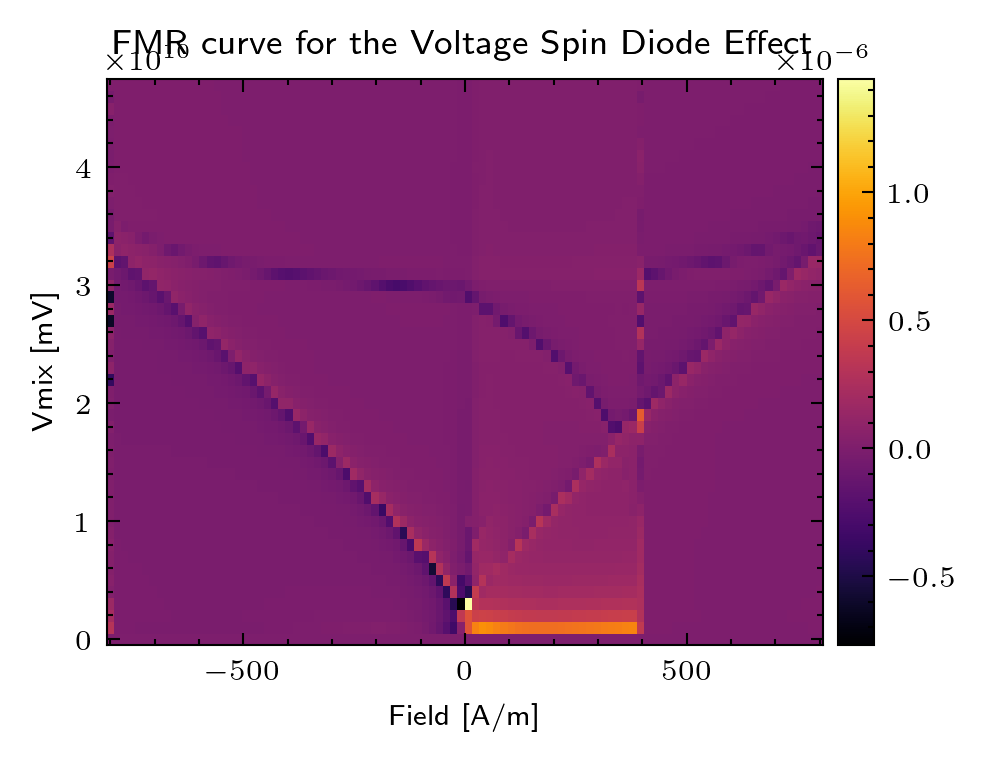

In [4]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
import numpy as np
from cmtj.utils import Filters

VSD = np.asarray(VSD, dtype=np.float32)

with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    im = ax.pcolor(
        Hspace / 1e3,
        frequencies,
        Filters.detrend_axis(VSD, axis=1),
        shading='auto',
        cmap='inferno',
    )
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')
    ax.set_xlabel("Field [A/m]")
    ax.set_ylabel("Vmix [mV]")
    ax.set_title("FMR curve for the Voltage Spin Diode Effect")
plt.show()

## Convenience procedure
You can also use the functions provided in the `cmtj.utils.procedures` package to perform the VSD experiment. The function `VSD_procedure` takes the junction, the field range, the frequency and the number of points in the field range as arguments. It returns the field and the Vmix values.
Another procedure -- PIMM, illustrated below -- is the one that performs the PIMM experiment. It takes the junction, the field range, and resistance parameter object as an input. 

In that way, you don't have to write PIMM or VSD procedures each time yourself.

Computing PIMM: 100%|██████████| 200/200 [00:27<00:00,  7.38it/s]


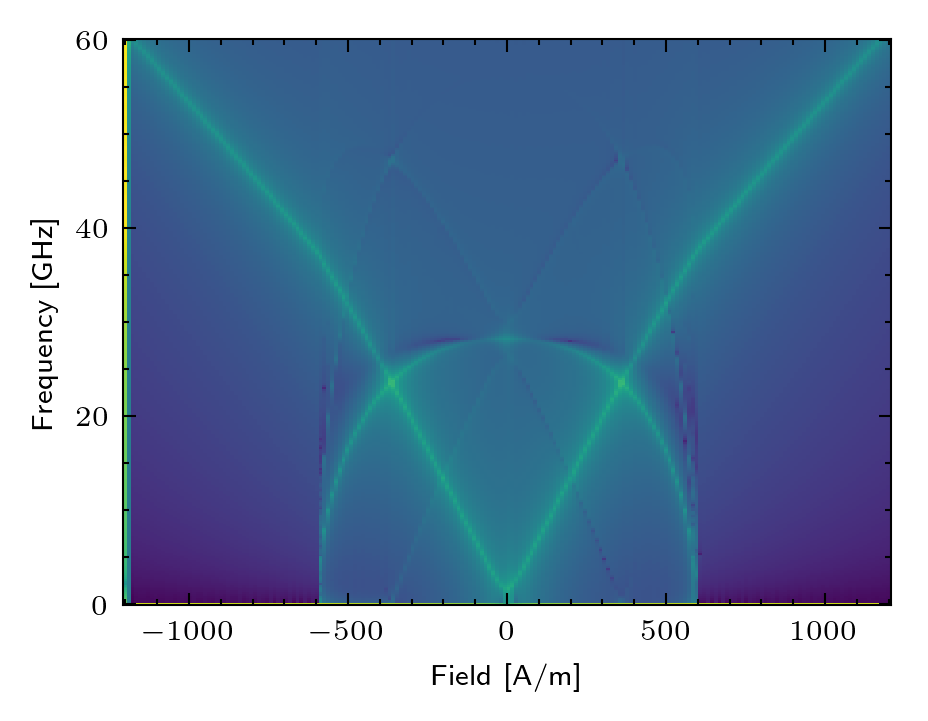

In [5]:
import matplotlib.pyplot as plt
from cmtj.utils.linear import FieldScan
from cmtj.utils.procedures import ResistanceParameters, PIMM_procedure

rp = ResistanceParameters(Rxx0=100,
                          Rxy0=1,
                          Rsmr=-0.46,
                          Rahe=-2.7,
                          Ramr=-0.24,
                          l=30,
                          w=20)

# approximate demagnetisation tensor
demag = [CVector(0, 0, 0), CVector(0, 0, 0), CVector(0, 0, 1)]
alpha = 0.005
Kdir = CVector(1, 0, 0)
Ms = 1.65
l1 = Layer("free",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=3.99e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)

l2 = Layer("bottom",
           mag=CVector(0, 0, 1),
           anis=Kdir,
           Ms=Ms,
           thickness=4e-9,
           cellSurface=0,
           demagTensor=demag,
           damping=alpha)
J1 = -1.78e-3
J2 = -1.69e-4

K1 = K2 = 1.05e3
int_step = 4e-14

j1 = Junction([l1, l2], 100, 102)

j1.setLayerAnisotropyDriver("all", ScalarDriver.getConstantDriver(K1))
j1.setIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J1))
j1.setQuadIECDriver("free", "bottom", ScalarDriver.getConstantDriver(J2))
Hscan, Hvecs = FieldScan.amplitude_scan(-1200e3, 1200e3, 200, 89, 90)

spectrum, freqs, output = PIMM_procedure(j1,
                                         Hvecs=Hvecs,
                                         int_step=int_step,
                                         resistance_params=[rp, rp],
                                         max_frequency=60e9)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(dpi=300)
    ax.pcolor(Hscan / 1e3,
              freqs / 1e9,
              np.log10(np.squeeze(spectrum.T)),
              shading='auto',
              cmap='viridis')
    ax.set_xlabel("Field [A/m]")
    ax.set_ylabel("Frequency [GHz]")

## STT
We may now transition to simulating Spin Torque Oscillators. As mentioned before, these are called the oscillators because they can sustain the oscillating magnetisation. 

This experiment is much simpler than the previous one. Like before, we will set up our layers, but this time, we will enable the STT contributions and we will invoke the critical current densities.

Note, we turn the STT in the free layer, which has now the magnetisation in the -z direction.
Additionally, we lower the free layer anisotropy and we turn off the coupling (for simplicity).

We also slightly tilt the bottom layer's magnetisation in order to invoke the torque on the spin torque. 

In [6]:
from typing import List, Dict
from cmtj.utils.plotting import get_sphere
x, y, z = get_sphere()

def plot_trajectories(log: Dict[str, List[float]], title: str):
    with plt.style.context(['science', 'nature']):
        fig = plt.figure(figsize=(4, 3), dpi=250)
        ax = fig.add_subplot(1, 2, 1, projection='3d')
        m = np.asarray([log[f'free_mx'], log[f'free_my'], log[f'free_mz']])
        ax.plot3D(m[0], m[1], m[2], color='blue')
        ax.set_axis_off()
        ax.plot_surface(x,
                        y,
                        z,
                        rstride=2,
                        cstride=2,
                        color='c',
                        alpha=0.3,
                        linewidth=0.1)
        ax.scatter([0], [0], [1], color='crimson', alpha=1.0, s=50)
        ax2 = fig.add_subplot(1, 2, 2)
        ax2.plot(log['time'], log['R_free_bottom'])
        ax2.set_xlabel("Time [s]")
        ax2.set_ylabel("Resistance [Ohm]")
        fig.suptitle(title)
        fig.tight_layout()

Steps in simulation: 20000
Write every: 1
Simulation time = 0[s]


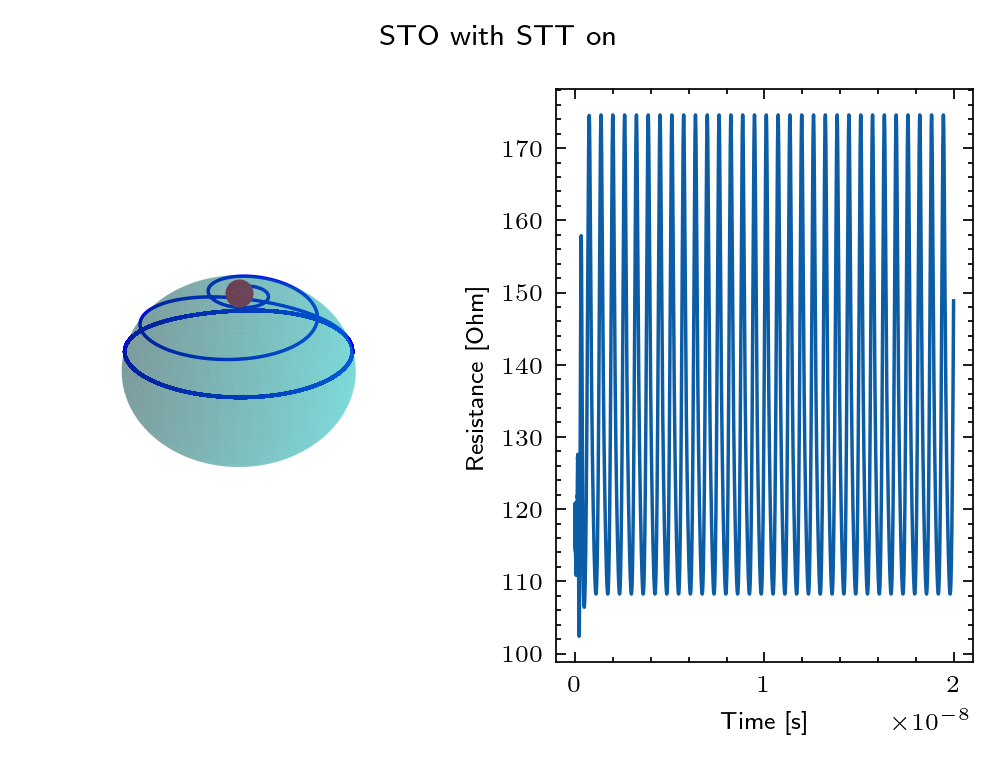

In [7]:
demagTensor = [CVector(0., 0., 0.), CVector(0., 0., 0.), CVector(0., 0., 1.0)]

damping = 0.3
currentDensity = 5e10
beta = 1
spinPolarisation = 1.0

l1 = Layer.createSTTLayer(id="free",
                          mag=CVector(0., 0., 1.),
                          anis=CVector(0, 0., 1.),
                          Ms=1.,
                          thickness=1.4e-9,
                          cellSurface=7e-10 * 7e-10,
                          demagTensor=demagTensor,
                          damping=damping,
                          SlonczewskiSpacerLayerParameter=1.0,
                          spinPolarisation=spinPolarisation,
                          beta=beta)
l2 = Layer(id="bottom",
           mag=CVector(0., 1., 1.),
           anis=CVector(0, 1., 1.),
           Ms=1.2,
           thickness=3e-9,
           cellSurface=7e-10 * 7e-10,
           demagTensor=demagTensor)

l1.setReferenceLayer(CVector(0, 1., 1.))
junction = Junction([l1, l2], 100, 200)

junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver(300e3))
junction.setLayerAnisotropyDriver("bottom",
                                  ScalarDriver.getConstantDriver(1500e3))
junction.setIECDriver("free", "bottom",
                      ScalarDriver.getConstantDriver(-2.5e-6))
# current driver
junction.setLayerCurrentDriver("free",
                               ScalarDriver.getConstantDriver(currentDensity))

junction.runSimulation(20e-9, 1e-12, 1e-12, True, False)
log = junction.getLog()
plot_trajectories(log, title="STO with STT on")

We will also run the same simulation but with the STT turned off, to see if the spin polarised current flow actually helps to sustain the oscillations. We see that the magnetisation stays still -- as becomes evident in the 3D plot -- we can only see a single dot.

Steps in simulation: 20000
Write every: 1
Simulation time = 0[s]


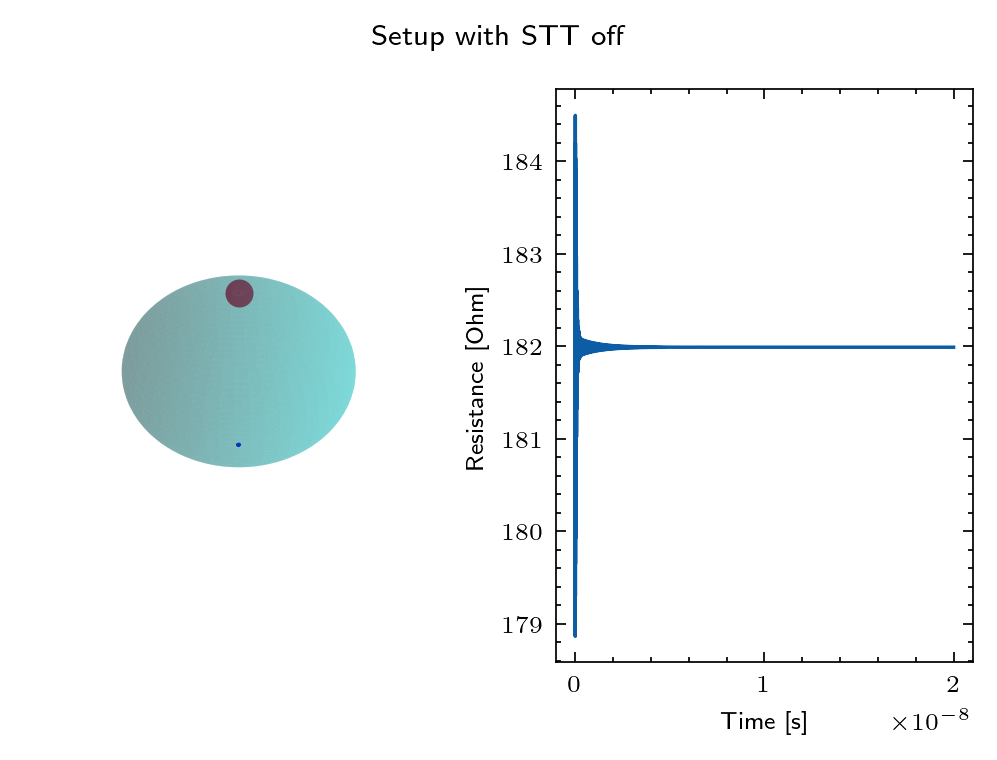

In [8]:
l1 = Layer(id="free",
           mag=CVector(0., 0., -1.),
           anis=CVector(0, 0., 1.),
           Ms=1.2,
           thickness=1.4e-9,
           cellSurface=7e-10 * 7e-10,
           demagTensor=demagTensor)
l2 = Layer(id="bottom",
           mag=CVector(0., 1., 1.),
           anis=CVector(0, 1., 1.),
           Ms=1.2,
           thickness=3e-9,
           cellSurface=7e-10 * 7e-10,
           demagTensor=demagTensor)

junction = Junction([l1, l2], 100, 200)
junction.setLayerAnisotropyDriver("free",
                                  ScalarDriver.getConstantDriver(800e3))
junction.setLayerAnisotropyDriver("bottom",
                                  ScalarDriver.getConstantDriver(1500e3))
junction.setIECDriver("free", "bottom",
                      ScalarDriver.getConstantDriver(-2.5e-6))
# current driver
junction.setLayerCurrentDriver("free",
                               ScalarDriver.getConstantDriver(currentDensity))
junction.runSimulation(20e-9, 1e-12, 1e-12, True, False)
log = junction.getLog()
plot_trajectories(log, title="Setup with STT off")